## In this notebook, you will implement a two-layer neural network model and stochastic gradient descent with momentum in numpy to classify CIFAR-10 images.

In [7]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# preprocess the data
x_train = x_train.reshape(x_train.shape[0], -1).astype('float')
x_test = x_test.reshape(x_test.shape[0], -1).astype('float')
y_train = y_train.squeeze()
y_test = y_test.squeeze()

x_train = x_train - x_train.mean(axis=1, keepdims=True)
x_train = x_train / x_train.std(axis=1, keepdims=True)
x_test = x_test - x_test.mean(axis=1, keepdims=True)
x_test = x_test / x_test.std(axis=1, keepdims=True)

2022-09-25 17:37:44.131986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Implement the forward and backward function for a two-layer neural network

In [285]:
class FullyConnectedNet():
  def __init__(self, hidden_dim, input_dim=3072, num_classes=10):
    super(FullyConnectedNet, self).__init__()
    self.params = {}
    self.params['W1'] = np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim/2)
    self.params['b1'] = np.zeros(hidden_dim)
    self.params['W2'] = np.random.randn(hidden_dim, num_classes)/np.sqrt(hidden_dim/2)
    self.params['b2'] = np.zeros(num_classes)
    self.grads = {}
    self.grads['W1'] = np.zeros_like(self.params['W1'])
    self.grads['b1'] = np.zeros_like(self.params['b1'])
    self.grads['W2'] = np.zeros_like(self.params['W2'])
    self.grads['b2'] = np.zeros_like(self.params['b2'])
        
  def forward(self, x):
    """Forward pass: linear -- ReLU -- linear
    
    Arguments:
        x: 2D numpy array of shape (batch_size, input_dim)
        
    Returns:
        scores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays, used for backward pass
    """
    ############################Write your code in this block (20 points)#####################
    


    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = x.shape
    
    z = np.dot(x,W1) + b1
    # First ReLU
    h = np.maximum(z, 0)
    scores = np.dot(h,W2) + b2
    
    cache = (x, N, h, z, W1, W2)



    

    
    #################################End of your code#########################################
    return scores, cache
    
  def backward(self, dscores, cache):
    """Backward pass
    
    Arguments:
        dscores: 2D numpy array of shape (batch_size, num_classes)
        cache: a tuple of numpy arrays saved from forward pass
        
    Returns:
        no explicit variable returned
        update self.grads['W1'], self.grads['b1'], self.grads['W2'], self.grads['b2']
    """
    #############################Write your code in this block (30 points)######################
    


    dh = np.dot(dscores, cache[5].T)
    dz = np.dot(dscores, cache[5].T) * (cache[3] > 0)  # (N, H)
    
    #compute gradient for parameters
    self.grads['W2'] = np.dot(cache[2].T, dscores) / cache[1]      # (H, C)
    self.grads['b2'] = np.sum(dscores, axis=0) / cache[1]      # (C,)
    self.grads['W1'] = np.dot(cache[0].T, dz) / cache[1]        # (D, H)
    self.grads['b1'] = np.sum(dz, axis=0) / cache[1]       # (H,)
    
    # add reg term
    self.grads['W2'] += 1e-5 * cache[5]
    self.grads['W1'] += 1e-5 * cache[4]

    




    
    ##################################End of your code##########################################
    return

In [286]:
# The Cross Entropy Loss has been implemented for you
def cross_entropy_loss(scores, y, eps=1e-8):
  """Calculate cross entropy loss and its gradient with respect to scores
  
  Arguments:
      scores: 2D numpy array of shape (batch_size, num_classes), predicted class scores
      y: 1D numpy array of shape (batch_size,), true class labels (from 0 to num_classes-1)
      
  Returns:
      loss: scalar
      dscores: 2D numpy array of shape (batch_size, num_classes), loss's gradient with respect to scores
      
  """
  scores -= scores.max()
  exp = np.exp(scores)
  exp = np.maximum(exp, eps)
  logits = - scores[range(scores.shape[0]), y] + np.log(exp.sum(axis=1))
  loss = logits.mean()
  dscores = np.zeros_like(scores)
  dscores[range(scores.shape[0]), y] = -1
  dscores += exp/exp.sum(axis=1, keepdims=True)
  dscores /= scores.shape[0]
  return loss, dscores

# Implement SGD with momentum
Initialize $m^{(0)}=0$

After $k$ steps, update $m^{(k+1)}$ and $\theta^{(k+1)}$:
$$m^{(k+1)}=\beta \cdot m^{(k)} + \nabla_{\theta} $$
$$\theta^{(k+1)}=\theta^{(k)} - \alpha \cdot m^{(k+1)}$$
If you want to have a deep understanding of SGD with momentum, I recommend [this article](https://distill.pub/2017/momentum).

In [287]:
class SGD():
  def __init__(self, params, alpha, beta=0):
    """
    Arguments:
      params: a dictionary, with keys being variable names, and values numpy arrays
      alpha: learning rate as shown in the formula in above text cell
      beta: the momentum coefficient, as shown in the formula in the above text cell;
        if beta = 0, then it becomes vallina SGD; Can you figure out why?
    """    
    self.params = params
    self.alpha = alpha
    self.beta = beta
    # Initially, set the momentum m = 0 for all parameters
    self.momentum = {n: np.zeros_like(p) for n, p in self.params.items()}

  def step(self, grads):
    """Perform gradient descent
    Arguments:
        grads: a dictionary, with the same keys as self.params, storing the corresponding gradients;
               for example, grads['W1'] is the gradient with respect to self.params['W1']
    Returns:
        No explicit returns
        Update self.params internally
    """
    #Hint: self.params is a dictionary of parameters,
    ###### use a for loop to iterate all the items from self.params,
    ###### use the formula in the above text cell to update each parameter;
    ###### Note self.momentum and grads are all dictionaries with the same keys as self.params
    ##############################Write your code in this block (20 points)######################
    
    for i in self.params.keys():
        #print(i)
        self.momentum[i] = (self.beta)*(self.momentum[i]) + grads[i]
        self.params[i] = self.params[i] - alpha*(self.momentum[i])

           



    
    ###################################End of your code##########################################
    return

# Test your implementation using the following code

In [288]:
hidden_dim = 200
model = FullyConnectedNet(hidden_dim=hidden_dim)

In [289]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
print(f'Before training, training accuracy={acc_train}, test accuracy={acc_test}')

Before training, training accuracy=0.07292, test accuracy=0.075


In [290]:
loss_history = []
acc_train_history = []
acc_val_history = []

In [291]:
num_iters = 2000
batch_size = 500
alpha = 1e-2
beta = 0.9
optimizer = SGD(model.params, alpha=alpha, beta=beta)
print_every = num_iters//20
for i in range(num_iters):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')

1 loss=3.016896593928264, acc_train=0.076, acc_val=0.064
100 loss=2.742816155465817, acc_train=0.094, acc_val=0.088
200 loss=2.5670117425434493, acc_train=0.152, acc_val=0.16
300 loss=2.3668255767217534, acc_train=0.196, acc_val=0.14
400 loss=2.395168865400764, acc_train=0.18, acc_val=0.172
500 loss=2.3276700707024545, acc_train=0.184, acc_val=0.2
600 loss=2.3162083018874218, acc_train=0.224, acc_val=0.21
700 loss=2.213133495783145, acc_train=0.23, acc_val=0.198
800 loss=2.1790269994919162, acc_train=0.24, acc_val=0.218
900 loss=2.180045140862952, acc_train=0.252, acc_val=0.264
1000 loss=2.090071266234527, acc_train=0.268, acc_val=0.224
1100 loss=1.9745335346215787, acc_train=0.286, acc_val=0.27
1200 loss=2.054085404044417, acc_train=0.288, acc_val=0.236
1300 loss=2.0634405397559457, acc_train=0.288, acc_val=0.286
1400 loss=2.073347591978443, acc_train=0.306, acc_val=0.294
1500 loss=2.050503831093237, acc_train=0.312, acc_val=0.28
1600 loss=2.022117097510687, acc_train=0.304, acc_val=0

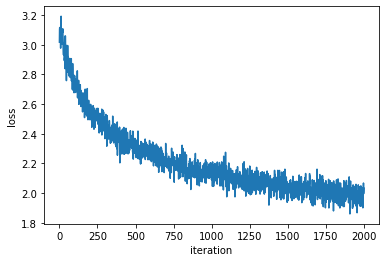

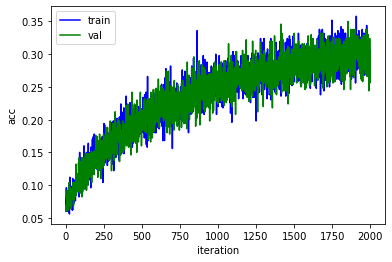

In [292]:
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

In [293]:
y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')

After training, training accuracy=0.3049, test accuracy=0.2994


# Try different hyperparameters: hidden_dim, lr, batch_size, num_iters, find one that can achieve the best test accuracy

1 loss=2.7139688099598427, acc_train=0.14, acc_val=0.12
50 loss=1.9886296991856343, acc_train=0.26, acc_val=0.24
100 loss=1.838223224106724, acc_train=0.34, acc_val=0.43
150 loss=1.7632144981553861, acc_train=0.38, acc_val=0.3
200 loss=1.5179531580037606, acc_train=0.44, acc_val=0.48
250 loss=1.9778858353510445, acc_train=0.29, acc_val=0.39
300 loss=1.6244286895355813, acc_train=0.42, acc_val=0.42
350 loss=1.5277724388014315, acc_train=0.45, acc_val=0.37
400 loss=1.5779174800333235, acc_train=0.39, acc_val=0.55
450 loss=1.6513287839265494, acc_train=0.47, acc_val=0.35
500 loss=1.5984428897829188, acc_train=0.47, acc_val=0.36
550 loss=1.4497363426328735, acc_train=0.5, acc_val=0.44
600 loss=1.5092605532544896, acc_train=0.49, acc_val=0.47
650 loss=1.517672501639114, acc_train=0.5, acc_val=0.56
700 loss=1.591655131568027, acc_train=0.41, acc_val=0.42
750 loss=1.4363950174919942, acc_train=0.52, acc_val=0.41
800 loss=1.6084137242931018, acc_train=0.43, acc_val=0.4
850 loss=1.4637431096033

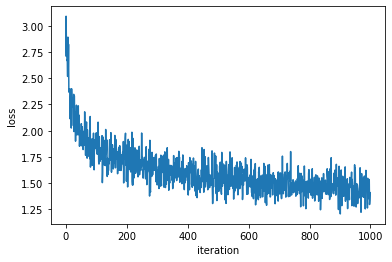

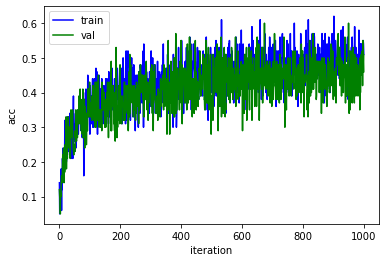

After training, training accuracy=0.50474, test accuracy=0.4573


In [294]:
###############Modify these hyperparameters and find the best ones (20 points)##################
###############You can write a loop to search for the best parameters if your want##############
hidden_dim = 300
alpha = 1e-1
beta = 0.9
batch_size = 100
num_iters = 1000
#################################################################################################

model = FullyConnectedNet(hidden_dim=hidden_dim)
optimizer = SGD(model.params, alpha=alpha, beta=beta)
loss_history = []
acc_train_history = []
acc_val_history = []
print_every = num_iters//20
for i in range(num_iters):
    idx = np.random.choice(x_train.shape[0], batch_size)
    x_batch = x_train[idx]
    y_batch = y_train[idx]
    scores, cache = model.forward(x_batch)
    loss, dscores = cross_entropy_loss(scores, y_batch)
    model.backward(dscores, cache)
    optimizer.step(model.grads)
    loss_history.append(loss.item())
    acc_train = np.mean(scores.argmax(axis=1) == y_batch)
    acc_train_history.append(acc_train.item())
    # test accuracy
    idx = np.random.choice(x_test.shape[0], batch_size)
    x_batch = x_test[idx]
    y_batch = y_test[idx]
    scores, cache = model.forward(x_batch)
    acc_val = np.mean(scores.argmax(axis=1) == y_batch)
    acc_val_history.append(acc_val.item())
    if i == 0 or i == num_iters-1 or (i+1)%print_every == 0:
        print(f'{i+1} loss={loss}, acc_train={acc_train}, acc_val={acc_val}')
        
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()
plt.plot(acc_train_history, 'b-', label='train')
plt.plot(acc_val_history, 'g-', label='val')
plt.xlabel('iteration')
plt.ylabel('acc')
plt.legend()
plt.show()

y_pred, _ = model.forward(x_train)
acc_train = np.mean(y_pred.argmax(axis=1) == y_train)
y_pred, _ = model.forward(x_test)
acc_test = np.mean(y_pred.argmax(axis=1) == y_test)
## You should achieve a test accuracy at least 0.4
print(f'After training, training accuracy={acc_train}, test accuracy={acc_test}')